# Methods of Estimations

In `Orbit`, we mainly support two methods to estimate model parameters (a.k.a posteriors in Bayesian).

1. Maximum a Posteriori (MAP)
2. Markov Chain Monte Carlo (MCMC)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import ETS
from orbit.diagnostics.plot import plot_predicted_data

In [2]:
print(orbit.__version__)

1.1.1


In [3]:
# load data
df = load_iclaims()
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]
response_col = 'claims'
date_col = 'week'

## Maximum a Posteriori (MAP)

To use MAP method, one can simply specify `estimator='stan-map'` when instantiating a model. The advantage of MAP estimation is a faster computational speed. We also provide inference for MAP method, with the caveat that the uncertainty is mainly generated by bootstraping the noise process and as such we may not observe the uncertainty band from seasonality or other components.

In [4]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

CPU times: user 30.5 ms, sys: 8.62 ms, total: 39.1 ms
Wall time: 269 ms


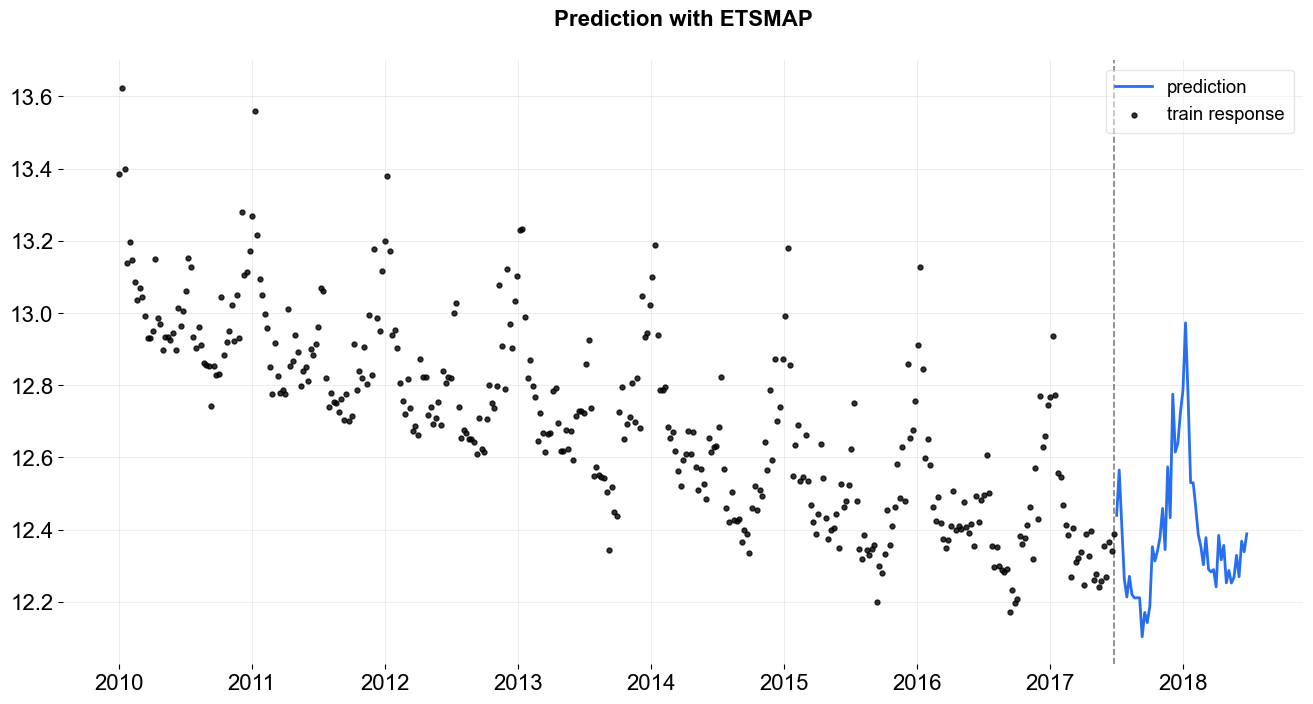

In [5]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETSMAP')

To have the uncertainty from MAP, one can speicify `n_bootstrap_draws` (default to be -1).

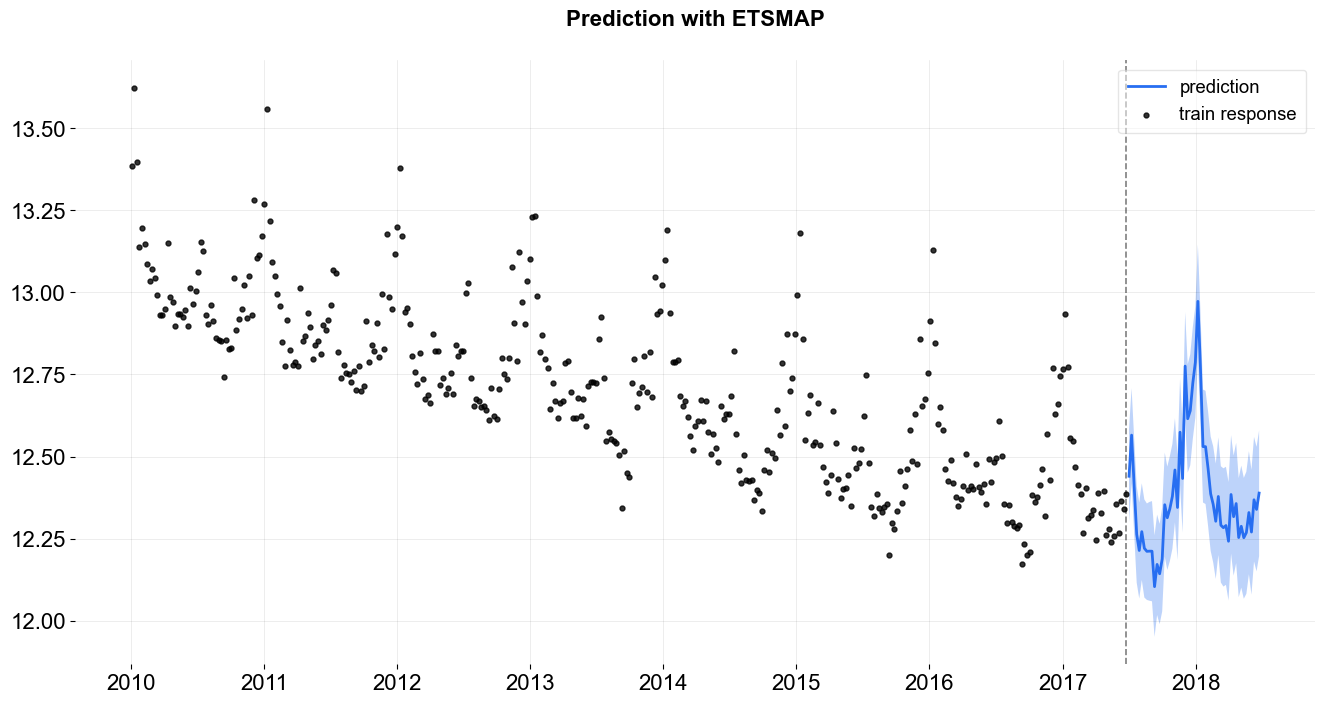

In [6]:
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    n_bootstrap_draws=1e4
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETSMAP')

## MCMC

To use MCMC method, one can specify `estimator='stan-mcmc'` (also the default) when instantiating a model.  Compared to MAP, it usually takes longer time to fit a full Bayesian models where **No-U-Turn Sampler (NUTS)** [(Hoffman and Gelman 2011)](https://arxiv.org/abs/1111.4246) is carried out under the hood. The advantage is that the inference and estimation are usually more robust.

### MCMC - Full

In [7]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
    num_warmup=400,
    num_sample=400,
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

CPU times: user 387 ms, sys: 50.1 ms, total: 438 ms
Wall time: 1.04 s


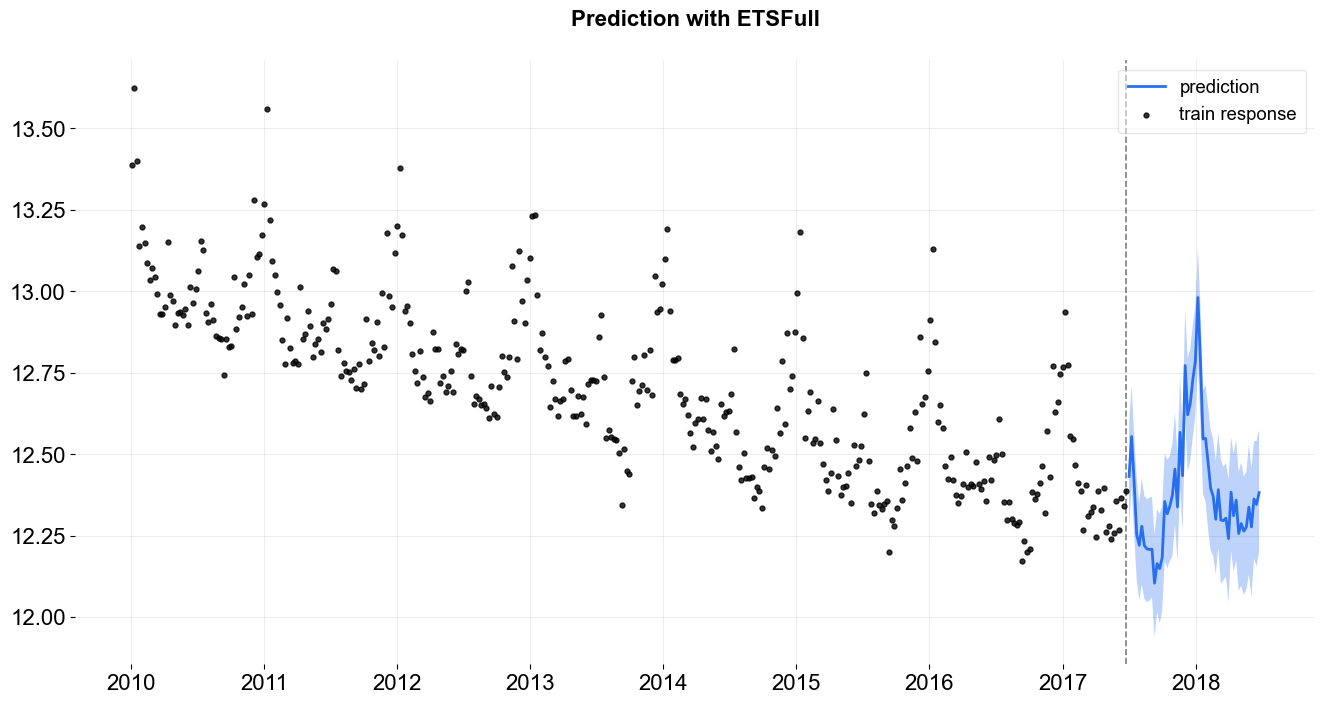

In [8]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETSFull')

You can also access the posterior samples by the attribute of `._posterior_samples` as a `dict`.

In [9]:
ets._posterior_samples.keys()

odict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

### MCMC - Point Estimation
One can also have the point estimates via MCMC by specifying `point_method` as `mean` or `median` via `.fit`.
 

Just like the full Bayesian method, it runs through the MCMC algorithm which is **NUTS** by default. The difference from a full model is that it aggregates the posterior samples first based on mean or median then does the prediction once using the aggreated posteriors.

In [10]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
)

CPU times: user 239 µs, sys: 111 µs, total: 350 µs
Wall time: 355 µs


In [11]:
# specify point_method
ets.fit(df=train_df, point_method='mean')
predicted_df = ets.predict(df=test_df)

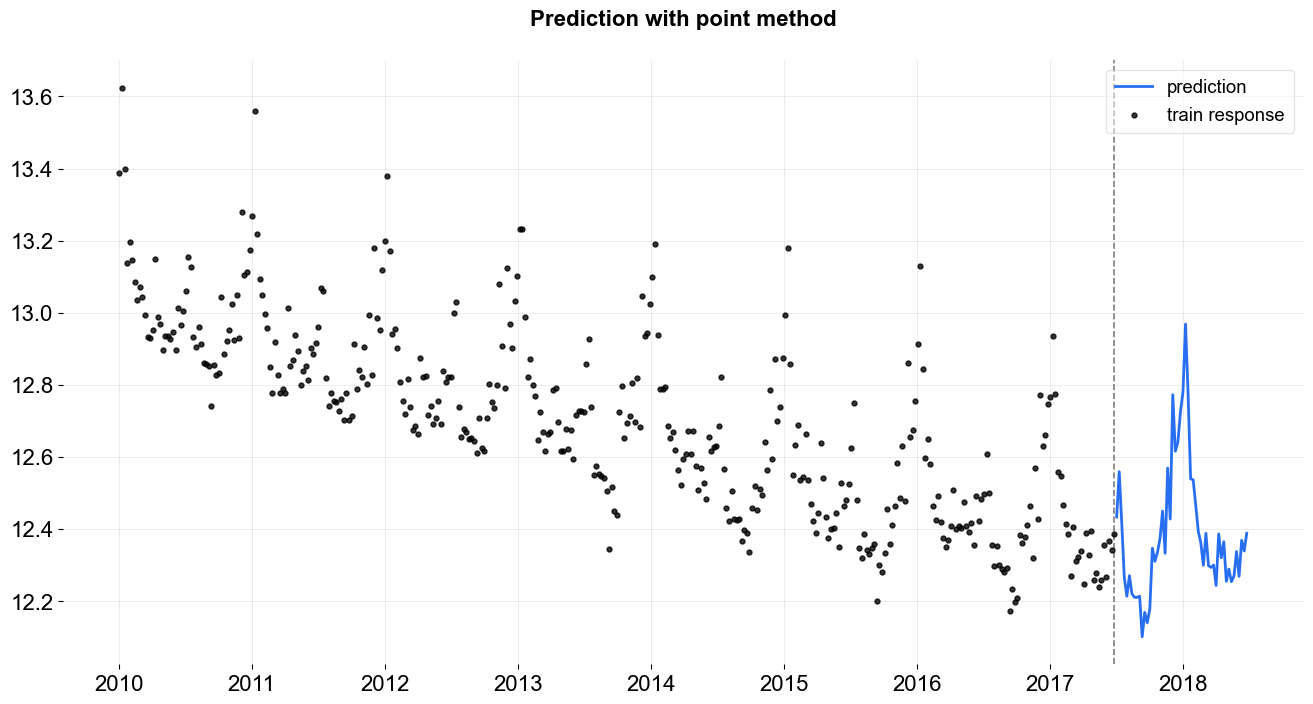

In [12]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, 
                        title='Prediction with point method')

Similarly, one can also specify `n_bootstrap_draws` to have the uncertainty for the point estimates.

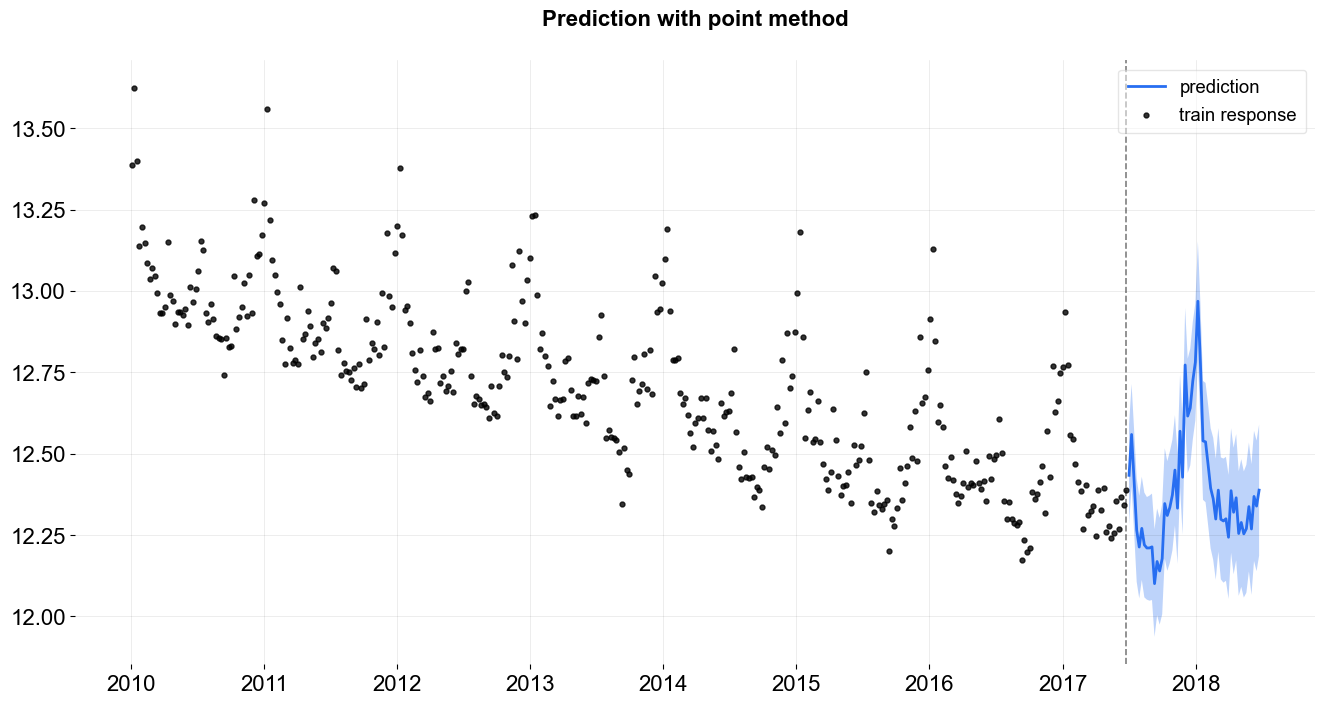

CPU times: user 1.18 s, sys: 193 ms, total: 1.38 s
Wall time: 1.62 s


In [13]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
    n_bootstrap_draws=1e4,
)
# specify point_method
ets.fit(df=train_df, point_method='mean')
predicted_df = ets.predict(df=test_df)

_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, 
                        title='Prediction with point method')